<a href="https://colab.research.google.com/github/MANOJHRMANOJHR/ai_assignments/blob/main/svm_kernels_margins_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Linear SVM CV accuracy: 0.9794 ± 0.0033
RBF    SVM CV accuracy: 0.9839 ± 0.0060
Best RBF params: {'C': 10, 'gamma': 0.01}, best CV accuracy: 0.9827


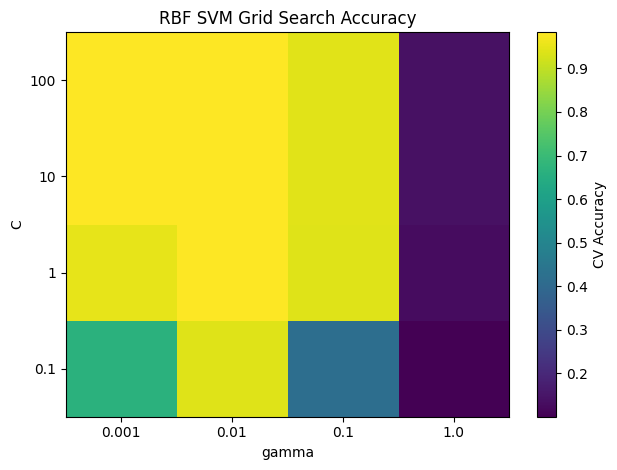

Saved: outputs/svm/heatmap_rbf.png


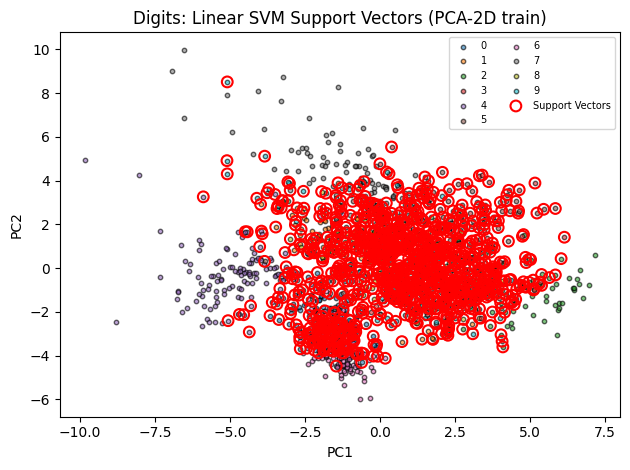

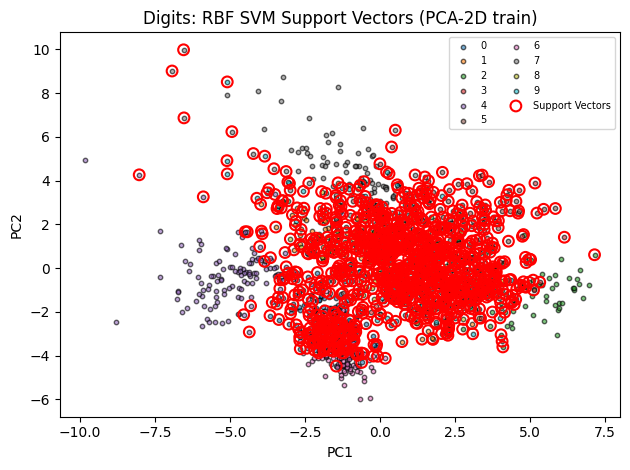

Saved: outputs/svm/sv_linear.png, outputs/svm/sv_rbf.png


In [1]:
# svm_kernels_margins_digits.py
# Digits dataset: Linear vs RBF SVM with grid search over (C, gamma),
# support-vector visualization (in PCA 2D), and accuracy heatmap.

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA


def ensure_out():
    os.makedirs("outputs/svm", exist_ok=True)


def heatmap(Z, Cs, gammas, title, fname):
    plt.figure()
    im = plt.imshow(Z, origin="lower", aspect="auto")
    plt.colorbar(im, label="CV Accuracy")
    plt.xticks(np.arange(len(gammas)), gammas)
    plt.yticks(np.arange(len(Cs)), Cs)
    plt.xlabel("gamma")
    plt.ylabel("C")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()


def plot_sv_2d(clf, X2d, y, title, fname):
    plt.figure()
    # Plot data points
    for c in np.unique(y):
        idx = (y == c)
        plt.scatter(X2d[idx, 0], X2d[idx, 1], s=10, edgecolors='k',
                    alpha=0.6, label=str(c))
    # Plot support vectors
    sv = clf.support_vectors_
    plt.scatter(sv[:, 0], sv[:, 1], s=60, facecolors='none',
                edgecolors='r', linewidths=1.5, label="Support Vectors")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(loc="best", fontsize=7, ncol=2)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()


def main():
    ensure_out()

    X, y = load_digits(return_X_y=True)

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Baseline Linear and RBF SVMs
    lin = SVC(kernel="linear", C=1.0)   # Using SVC to access support_vectors_
    rbf = SVC(kernel="rbf", C=1.0, gamma="scale")

    lin_scores = cross_val_score(lin, Xs, y, cv=cv, scoring="accuracy")
    rbf_scores = cross_val_score(rbf, Xs, y, cv=cv, scoring="accuracy")

    print(f"Linear SVM CV accuracy: {lin_scores.mean():.4f} ± {lin_scores.std():.4f}")
    print(f"RBF    SVM CV accuracy: {rbf_scores.mean():.4f} ± {rbf_scores.std():.4f}")

    # Grid search over C and gamma for RBF kernel
    param_grid = {"C": [0.1, 1, 10, 100],
                  "gamma": [1e-3, 1e-2, 1e-1, 1.0]}
    grid = GridSearchCV(SVC(kernel="rbf"), param_grid=param_grid,
                        cv=cv, scoring="accuracy", n_jobs=-1,
                        return_train_score=False)
    grid.fit(Xs, y)

    print(f"Best RBF params: {grid.best_params_}, best CV accuracy: {grid.best_score_:.4f}")

    means = grid.cv_results_["mean_test_score"].reshape(
        len(param_grid["C"]),
        len(param_grid["gamma"])
    )

    heatmap(means, param_grid["C"], param_grid["gamma"],
            "RBF SVM Grid Search Accuracy", "outputs/svm/heatmap_rbf.png")
    print("Saved: outputs/svm/heatmap_rbf.png")

    # Visualize support vectors in PCA 2D (train split)
    Xtr, Xte, ytr, yte = train_test_split(Xs, y, test_size=0.25,
                                          stratify=y, random_state=42)
    pca = PCA(n_components=2, random_state=42)
    Xtr2 = pca.fit_transform(Xtr)

    lin2 = SVC(kernel="linear", C=1.0).fit(Xtr2, ytr)
    rbf2 = SVC(kernel="rbf", C=grid.best_params_["C"],
               gamma=grid.best_params_["gamma"]).fit(Xtr2, ytr)

    plot_sv_2d(lin2, Xtr2, ytr,
               "Digits: Linear SVM Support Vectors (PCA-2D train)",
               "outputs/svm/sv_linear.png")

    plot_sv_2d(rbf2, Xtr2, ytr,
               "Digits: RBF SVM Support Vectors (PCA-2D train)",
               "outputs/svm/sv_rbf.png")

    print("Saved: outputs/svm/sv_linear.png, outputs/svm/sv_rbf.png")


if __name__ == "__main__":
    main()
